NOTE: This is not entirely my code. It was created by following the tutorial created by Nicholas Renotte on his YouTube video, found here:  https://www.youtube.com/watch?v=2eeYqJ0uBKE

1. Setup the game

In [1]:
# Import Super Mario Bros game
import gym_super_mario_bros
# Import Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import simplified controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

`SIMPLE_MOVEMENT` is nice because it restricts which actions our agent can take. Printing the `SIMPLE_MOVEMENT` below, you can see that the options are quite limited.

In [2]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [2]:
# Setup the environment (the game)

env = gym_super_mario_bros.make('SuperMarioBros-v0')
print(f'Here is the number of actions if we dont use SIMPLE_MOVEMENT: {env.action_space}')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
print(f'Once we have limited the aciton space with SIMPLE_MOVEMENT, mario can only do {env.action_space} actions')

Here is the number of actions if we dont use SIMPLE_MOVEMENT: Discrete(256)
Once we have limited the aciton space with SIMPLE_MOVEMENT, mario can only do Discrete(7) actions


As can be seen above, limiting the action space is beneficial to us as it allows the agent to learn faster when the possible choices of actions it can make are limited. 

In [4]:
# done flag tells us whether or not we need to restart the game
done = True
for step in range(100000):
    if done:
        env.reset() # This starts the game from the initial start state
    # The step function allows the agent to take the supplied action. 
    # .sample() chooses a random action from the action space within the environment and passes that into the step()
    state, reward, done, info = env.step(env.action_space.sample())
    # render will show the game on the screen
    env.render()
env.close()

c:\Users\gex71\miniconda3\envs\marioEnv\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
c:\Users\gex71\miniconda3\envs\marioEnv\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

In [5]:
env.close() # use this standalone line to close the environment. 

2: Preprocess the environment

In [3]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib
from matplotlib import pyplot as plt

c:\Users\gex71\miniconda3\envs\marioEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FrameStack, imported above, allows us to store several frames of the game at a time. This is important because if you look at a single frame of the game, you have no idea what the state actually is. If Mario is in the air, is he jumping? Falling? Wearing anti-gravity boots? Having a 'memory' of the last few frames of the game allows better interpretation of how you got to the state you are in. If Mario was lower in a previous frame than the current one, it can be inferred he is probably jumping at this point. 

The GrayScaleObservation cuts down the amount of information that the model is trying to process. If we didn't do that, we would be getting back 3 color channels from the game (Red, Blue, Green) and the model would look at all 3 when trying to learn from the current state. There is already a lot going on so if we cut down to a simplified black and white version, the agent will have one less thing that it needs to iterate over.

MatPlotLib is not necessary but will be used to show the benefits of frame stacking.

Here is the states shape: (240, 256, 3). Notice the 3 on the end, we have not grayscaled yet so you can see there are three channels, one per color
After grayscaling, you can see the shape ((240, 256, 1)) now has a 1 on the end. We have reduced one of the dimensions of data down by 2/3rds!


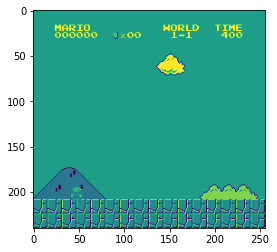

In [4]:
# 1. Create base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')

# 2. Simplify the controls with the SIMPLE_MOVEMENT action space
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state = env.reset()
print(f"Here is the states shape: {state.shape}. Notice the 3 on the end, we have not grayscaled yet so you can see there are three channels, one per color")
plt.imshow(state)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True) # keep_dim=True keeps the final 1 on the end of that shape, which we need to allow for frame stacking
gs_state = env.reset()
print(f"After grayscaling, you can see the shape ({gs_state.shape}) now has a 1 on the end. We have reduced one of the dimensions of data down by 2/3rds!")
plt.imshow(gs_state)
# 4. Wrap inside the dummy environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [4]:
state = env.reset()

In [11]:
for _ in range(10):
    state, reward, done, info = env.step([env.action_space.sample()])

# print(state.shape[3])


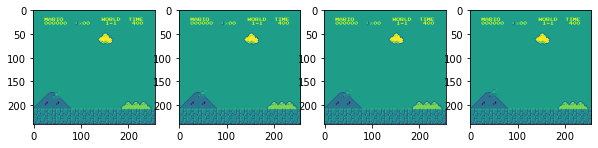

In [12]:
plt.figure(figsize=(10,8))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

Train the RL Model

In [5]:
# Import OS for file path management
import os
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [5]:
# This is blatantly copied from the tutorial, it allows you to save your model on x number of steps. 
# This is optional but if you want to be able to examine how the model behaves at certain points or after
# a certain number of training iterations, this is nice to have.
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, starting_point, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.starting_point = starting_point
    
    def _initcallback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if (self.n_calls+self.starting_point) % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls+self.starting_point))
            self.model.save(model_path)
        return True

In [6]:
# Here we make up directories that you want to save your training data to and log files. You can name these whatever you want.
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [6]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR, starting_point=10000)

NameError: name 'CHECKPOINT_DIR' is not defined

In [21]:
# This is a temp model that gets created once so you can start training
# PPO stands for Proximal Policy Optimization
# CNN Policies are for images
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [14]:
# Train the model, this is how it learns
# If you dont want to do the callback method, you can just remove it as it can create a lot of files that take up a lot of space
model.learn(total_timesteps=5000, callback=callback)

Logging to ./logs/PPO_5


c:\Users\gex71\miniconda3\envs\marioEnv-v2\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 152 |
|    iterations      | 1   |
|    time_elapsed    | 3   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 30            |
|    iterations           | 2             |
|    time_elapsed         | 33            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00022499822 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.94         |
|    explained_variance   | 0.0191        |
|    learning_rate        | 1e-06         |
|    loss                 | 156           |
|    n_updates            | 200           |
|    policy_gradient_loss | -0.000509     |
|    value_loss           | 478           |
-------------------------------------------
-----

In [ ]:
# to save the current model, as a manual save do the following line
# model.save('testNameForTheModel')

In [7]:
# Load the model (this is so we can either test or continue training from that point)
# PPO stands for Proximal Policy Optimization
model = PPO.load('./train/best_model_4000000')
model.set_env(env) # Uncomment this to set the environment when doing continual training

In [8]:
# Actually test the model!! 

# Start the game
state = env.reset()
while True:
    # 
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

c:\Users\gex71\miniconda3\envs\marioEnv\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
c:\Users\gex71\miniconda3\envs\marioEnv\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

In [16]:
state = env.reset()

c:\Users\gex71\miniconda3\envs\marioEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here is the states shape: (240, 256, 3). Notice the 3 on the end, we have not grayscaled yet so you can see there are three channels, one per color
After grayscaling, you can see the shape ((240, 256, 1)) now has a 1 on the end. We have reduced one of the dimensions of data down by 2/3rds!


c:\Users\gex71\miniconda3\envs\marioEnv\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
c:\Users\gex71\miniconda3\envs\marioEnv\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

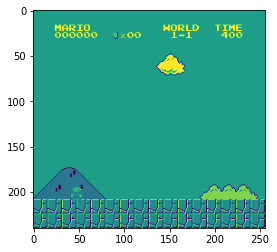

In [1]:
#With a fresh kernal restart the kernal if needed) just click this cell to run the model
# Import Super Mario Bros game
import gym_super_mario_bros
# Import Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import simplified controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib
from matplotlib import pyplot as plt
# Import OS for file path management
import os
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

# 1. Create base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')

# 2. Simplify the controls with the SIMPLE_MOVEMENT action space
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state = env.reset()
print(f"Here is the states shape: {state.shape}. Notice the 3 on the end, we have not grayscaled yet so you can see there are three channels, one per color")
plt.imshow(state)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True) # keep_dim=True keeps the final 1 on the end of that shape, which we need to allow for frame stacking
gs_state = env.reset()
print(f"After grayscaling, you can see the shape ({gs_state.shape}) now has a 1 on the end. We have reduced one of the dimensions of data down by 2/3rds!")
plt.imshow(gs_state)
# 4. Wrap inside the dummy environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, starting_point, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.starting_point = starting_point
    
    def _initcallback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if (self.n_calls+self.starting_point) % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls+self.starting_point))
            self.model.save(model_path)
        return True
    
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR, starting_point=10000)

model = PPO.load('./train/best_model_1750000') # Change the file name here to pick a different model (if you have one)

state = env.reset()
while True:
    # 
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()